# 1. Data Cleaning

#### Import Boston Marathon results from 2001 to 2017 (excluding 2013) as raw data in csv files

In [1]:
%matplotlib inline
import sys
print(sys.version)
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
1.16.2
0.24.2


Since data before and after 2013 comes from different sources, I will clean them separately. Data from 2014 is a little bit from both worlds. I will also pick it our alone and put it back separately.

* Import data before 2013

In [356]:
file_name = '{}.csv'
df_list = []
for i in range(2001, 2013):
    df_i = pd.read_csv(file_name.format(i))
    df_i['Year'] = i
    df_i.columns = [name.capitalize() for name in list(df_i.columns)]
    df_list.append(df_i)

df_part1 = pd.concat(df_list)
df_part1.head()

,Division,Name,City,Gender,Age,Official,Bib,Overall,State,Genderdiv,Net,Country,Year
0,2 / 32,"Nietlispach, Franz",Zeiningen,M,43,91.37,W1,2 / 35,NaN,2 / 29,91.37,SUI,2001
1,1 / 3254,"Ndereba, Catherine",Nairobi,F,28,143.88,F1,27 / 13408,NaN,1 / 4814,143.88,KEN,2001
2,15 / 3945,"Lagat, Elijah",Nandi District,M,34,137.98,1,17 / 13408,NaN,17 / 8594,137.98,KEN,2001
3,14 / 3945,"Abera, Gezahegne",Addis Ababa,M,22,137.07,2,16 / 13408,NaN,16 / 8594,137.07,ETH,2001
4,3 / 32,"Frei, Heinz",Etziken,M,43,91.97,W2,3 / 35,NaN,3 / 29,91.97,SUI,2001


* Extract the ranking columns from `Overall`, `Genderdiv`, and `Division`, and format into single ranking number.
> There's one missing value in `Division` causing the ValueError. I will simply remove it.

In [357]:
print(df_part1[df_part1['Division']=='-']['Name'].count())
df_part1 = df_part1[df_part1['Division'] != '-']

1


In [358]:
df_part1['Total_Runner'] = df_part1['Overall'].str.extract(r'/\s*(\d*)').astype(int)
df_part1['Overall'] = df_part1['Overall'].str.extract(r'(\d*)\s*/').astype(int)
df_part1['Genderdiv'] = df_part1['Genderdiv'].str.extract(r'(\d*)\s*/').astype(int)
df_part1['Division'] = df_part1['Division'].str.extract(r'(\d*)\s*/').astype(int)

* Import data After 2015

In [359]:
# data after 2015
file_name = '{}.csv'
df_list = []
for i in range(2015, 2018):
    df_i = pd.read_csv(file_name.format(i))
    df_i['Year'] = i
    df_i.columns = [name.capitalize() for name in list(df_i.columns)]
    df_list.append(df_i)

df_part2 = pd.concat(df_list)
df_part2 = df_part2.rename(columns={'M/f': 'Gender', 'Official time': 'Official', 'Gender': 'Genderdiv'})

* Change the finishing time format from H:MM:SS to minutes

In [360]:
# note that the running time is recorded differently from the part1 of the data
Distance_col = ['Official', 'Half']
distance_col_format = '{}k'
for i in range(5, 45, 5):
    Distance_col.append(distance_col_format.format(i))
print(Distance_col)
# Identified an outlier
for col in Distance_col:
    check_list = df_part2[col].str.split(':')
    for outlier in check_list:
        if len(outlier) < 3:
            break
    df_part2[df_part2[col] == outlier[0]]
    # Since there's only one outlier, I will simply drop it
    df_part2 = df_part2[df_part2[col] != outlier[0]]

    # now I'm converting the running time into minutes
    df_part2[col].str.split(':', expand = True)

    df_part2[col] = pd.to_numeric(df_part2[col].str.split(':', expand = True)[0]) * 60 \
                        + pd.to_numeric(df_part2[col].str.split(':', expand = True)[1])\
                        + round(pd.to_numeric(df_part2[col].str.split(':', expand = True)[2])/60,2)

['Official', 'Half', '5k', '10k', '15k', '20k', '25k', '30k', '35k', '40k']


* Import data in 2014

In [361]:
df_2014 = pd.read_csv('2014.csv')
df_2014.columns = [name.capitalize() for name in list(df_2014.columns)]
df_2014['Year'] = 2014

* change data type for distance columns

In [362]:
Distance_col.remove('15k')
for col in Distance_col:
    df_2014 = df_2014[df_2014[col] != '-']
    # remove official values = 0
    df_2014 = df_2014[df_2014[col] != 0]
    # transform the Official time to numeric values
    df_2014[col] = pd.to_numeric(df_2014[col])
Distance_col.append('15k')

/Users/CecilyS/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


* put them together

In [363]:
df_full = pd.concat([df_part1, df_2014, df_part2], ignore_index=True, sort = False)
df_full.reindex()
print(df_full.columns)

Index(['Division', 'Name', 'City', 'Gender', 'Age', 'Official', 'Bib',
       'Overall', 'State', 'Genderdiv', 'Net', 'Country', 'Year',
       'Total_Runner', 'Ctz', '5k', '10k', '20k', 'Half', '25k', '30k', '35k',
       '40k', 'Pace', 'Citizen', '15k', 'Proj time'],
      dtype='object')


* Add Columns for `First_name` and `Last_name`.

In [364]:
df_full['Last_name'] = df_full['Name'].str.extract(r'(\w*),')
df_full['First_name'] = df_full['Name'].str.extract(r', (\D*)')

In [365]:
df_full.describe()

,Division,Age,Overall,Genderdiv,Year,Total_Runner,5k,10k,20k,Half,25k,30k,35k,40k,15k
count,343430.000000,343430.000000,343430.000000,343430.000000,343430.000000,232744.000000,110686.000000,110686.000000,110686.000000,110686.000000,110686.000000,110686.00000,110686.000000,110686.000000,79037.000000
mean,1652.636575,41.267105,11245.386361,5788.252969,2009.753478,19876.421343,25.518299,51.119944,104.037512,109.834202,131.676476,161.00614,191.782347,222.402895,76.808071
std,1346.596669,10.800085,7072.640500,3741.003849,4.828481,3271.327150,4.041303,8.208698,17.640926,18.666338,23.195305,29.39534,35.965209,42.118675,12.254167
min,1.000000,18.000000,1.000000,1.000000,2001.000000,0.000000,7.750000,16.620000,36.100000,38.030000,45.800000,56.45000,67.420000,76.100000,44.950000
25%,556.000000,33.000000,5340.000000,2670.000000,2006.000000,17030.000000,22.580000,45.220000,91.580000,96.680000,115.430000,140.48000,166.680000,193.000000,68.050000
50%,1319.000000,41.000000,10712.000000,5375.000000,2010.000000,20348.000000,24.980000,49.970000,101.280000,106.900000,127.780000,155.87000,185.380000,214.880000,75.120000
75%,2445.000000,49.000000,16387.000000,8499.000000,2014.000000,22672.000000,27.800000,55.665000,113.230000,119.520000,143.550000,176.13000,210.670000,244.900000,83.250000
max,6979.000000,87.000000,31931.000000,17575.000000,2017.000000,23879.000000,86.950000,112.380000,224.350000,236.670000,289.020000,376.38000,449.330000,508.350000,161.750000


# 2. Sanity Check

### Missing Values
First, I want to check the number of missing values, or NaNs in each variable. 

* I start with the most important variable: finishing time - `Official`

In [366]:
print(df_full[df_full['Official'] == '-']['Name'].count())
print(df_full[df_full['Official'] == '0']['Name'].count())
print(df_full[df_full['Official'].isnull()]['Name'].count())

76
0
0


> About 76 of the records of official time is '-'. Remove them as missing values, and then change the data type to numeric.

In [367]:
df_full = df_full[df_full['Official'] != '-']
# transform the Official time to numeric values
df_full['Official'] = df_full['Official'].astype(float)

In [368]:
df_full['Official'].describe()

count    343354.000000
mean        237.490810
std          43.292074
min          78.420000
25%         207.480000
50%         230.620000
75%         261.330000
max         538.880000
Name: Official, dtype: float64

* Then I will look at each distance time, are there any missing records. This is for 2014 and on.

In [369]:
for col in Distance_col:
    print(col, df_full[(df_full[col].isnull()) & (df_full['Year']>=2014)]['Name'].count())

Official 0
Half 0
5k 0
10k 0
20k 0
25k 0
30k 0
35k 0
40k 0
15k 31649


> No missing values for distance records except for 15k, which is expected since the 15k records are missing in the 2014 dataset. 

* Lastly, check the missing values for all the variables. Any column that doesn't have the same value counts as the Name column, will be flagged

In [370]:
Counts_by_year = df_full.groupby('Year').count()

missing_values = pd.DataFrame(data = Counts_by_year['Name'])
for col in Counts_by_year.columns:
    if (Counts_by_year['Name'] == Counts_by_year[col]).sum() != 16:
        missing_values[col] = Counts_by_year['Name'] - Counts_by_year[col]

# Name column represents the total row counts. 
# All the other columns are the number of missing values in each variable
missing_values

,Name,City,State,Net,Total_Runner,Ctz,5k,10k,20k,Half,25k,30k,35k,40k,Pace,Citizen,15k,Proj time
Year,,,,,,,,,,,,,,,,,,
2001,13443,0,604,0,0,13443,13443,13443,13443,13443,13443,13443,13443,13443,13443,13443,13443,13443
2002,14622,0,613,0,0,14622,14622,14622,14622,14622,14622,14622,14622,14622,14622,14622,14622,14622
2003,17056,15,743,0,0,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056
2004,16783,22,748,0,0,16783,16783,16783,16783,16783,16783,16783,16783,16783,16783,16783,16783,16783
2005,17564,0,745,0,0,17564,17564,17564,17564,17564,17564,17564,17564,17564,17564,17564,17564,17564
2006,19715,0,1075,19715,0,19715,19715,19715,19715,19715,19715,19715,19715,19715,19715,19715,19715,19715
2007,20369,1,1105,0,0,20369,20369,20369,20369,20369,20369,20369,20369,20369,20369,20369,20369,20369
2008,21975,0,1296,0,0,21975,21975,21975,21975,21975,21975,21975,21975,21975,21975,21975,21975,21975
2009,22902,1,1370,22902,0,22902,22902,22902,22902,22902,22902,22902,22902,22902,22902,22902,22902,22902


From the table above, I noticed that some geographic information, such as `City` and `State`, were not complete. But the number of missing values from these 2 variables are a lot, so I will just ignore them.

The majority of `Citizen` columns are missing values, which won't add value to our following analysis, so I will just drop this column.

For columns `Net` and `Proj time`, there are a lot of missing values. I will just drop the two columns as we won't be using these two columns in the future analysis.

Finally, the distance time data before 2014 were missing due to incomplete data collection. I will ignore the missing before 2014 and only use data after 2014 to perform analysis that require these columns.

In [371]:
# drop Citizen, Net, and Proj time
df_full = df_full.drop(columns=['Citizen', 'Ctz', 'Net', 'Proj time'])

### Categorical Variables

Moving on to Categorical Variables, I want to make sure that the frequecy count in each category makes sense.

* First I want to check the `Total_Runner` by year

In [372]:
df_full.groupby(['Year', 'Total_Runner'])['Name']\
            .agg([('total','count')])\
            .sort_values(by = 'Year', ascending=False)

total
Year Total_Runner       
2012 21616.0       21540
     35.0             35
     21.0              1
2011 23879.0       23901
     32.0             32
     0.0              12
2010 29.0             28
     20.0             20
     22672.0       22670
2009 22849.0       22853
     29.0             29
     20.0             20
2008 21948.0       21947
     16.0             16
     12.0             12
2007 6.0               6
     20348.0       20331
     25.0             25
     0.0               7
2006 27.0             27
     6.0               6
     19682.0       19682
2005 17528.0       17528
     30.0             30
     6.0               6
2004 7.0               7
     16743.0       16713
     43.0             43
     0.0              20
2003 17030.0       17030
     25.0             25
     1.0               1
2002 6.0               6
     14573.0       14572
     44.0             44
2001 13408.0       13408
     35.0             35

* Looking at the data frame above, there are some noises that certain records are not from the main group. I will drop these noises. This is only for data on and before 2012.

In [373]:
df_full = df_full[(df_full['Total_Runner'] > 10000) | (df_full['Year'] > 2012)]
# check the counts again
df_full.groupby(['Year', 'Total_Runner'])['Name']\
            .agg([('total','count')])\
            .sort_values(by = 'Year', ascending=False)

,,total
Year,Total_Runner,
2012,21616.0,21540
2011,23879.0,23901
2010,22672.0,22670
2009,22849.0,22853
2008,21948.0,21947
2007,20348.0,20331
2006,19682.0,19682
2005,17528.0,17528
2004,16743.0,16713


Now it looks good. Even though for some years the total counts don't match exactly the official number of total runners, the variance is very small. It shouldn't have too much of the impact for the following analysis.

* Checking the row counts by year - 

In [374]:
df_full.groupby(['Year'])['Name']\
            .agg([('total','count')])\
            .sort_values(by = 'Year', ascending=False)

,total
Year,
2017,26259
2016,26481
2015,26297
2014,31649
2012,21540
2011,23901
2010,22670
2009,22853
2008,21947


Looks good.

### Numeric Variables

In this analysis, we will be looking at mainly numetric variables such as finishing time, age, ect. It's very important to make sure that the numeric variables are clean and make sense to proceed to the following analysis.

* I take a look at `Age` first.

In [375]:
df_full.groupby('Year')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2001,13408.0,38.817945,9.500090,18.0,31.0,39.0,45.0,79.0
2002,14572.0,39.051194,9.488257,18.0,32.0,39.0,45.0,87.0
2003,17030.0,40.337639,10.116035,18.0,33.0,40.0,47.0,81.0
2004,16713.0,40.430683,10.250092,18.0,33.0,40.0,47.0,82.0
2005,17528.0,40.549977,10.404580,18.0,33.0,41.0,48.0,83.0
2006,19682.0,40.625089,10.512091,18.0,33.0,41.0,48.0,78.0
2007,20331.0,40.675619,10.617422,18.0,32.0,41.0,48.0,79.0
2008,21947.0,41.050030,10.660710,18.0,33.0,41.0,48.0,81.0
2009,22853.0,40.965913,10.768819,18.0,32.0,41.0,48.0,81.0


`Age` column looks good. 

* Now I want to focus on the important variables in the analysis: `Official`, which is the finishing time for the runners.

In [376]:
df_full.groupby('Year')['Official'].describe()

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2001,13408.0,232.965168,40.073528,129.72,204.2800,227.52,255.2050,465.50
2002,14572.0,231.109430,40.096665,129.03,201.9200,226.04,253.4850,478.52
2003,17030.0,244.100473,41.942702,130.18,214.0200,238.65,268.8300,462.92
2004,16713.0,263.603142,45.318288,130.62,231.3200,259.63,292.5500,405.32
2005,17528.0,248.409544,43.210085,131.75,216.7700,243.36,275.9050,445.47
2006,19682.0,230.107669,36.331449,127.23,205.5300,224.78,249.7200,469.18
2007,20331.0,234.517458,38.746808,134.22,208.3500,228.67,254.5000,426.97
2008,21947.0,231.668751,38.032059,127.77,205.5800,226.20,251.6000,461.15
2009,22853.0,229.567789,37.247380,128.70,204.5700,224.07,248.3800,451.60


* Looking at the above dataframe, the min time for 2014 looks odd to me. My assumption here is that there might be some records that are not within the main category of the Boston Marathon - such as hand cyclists. After cross-checking with the official 1st finisher data from Wikipedia, I decided to align these records with the official data pulled from Wikipedia. 

In [377]:
df_full[df_full.Genderdiv == 1]\
        [['Year', 'First_name', 'Last_name', 'Overall', 'Division', 'Gender', 'Bib', 'Official']]

,Year,First_name,Last_name,Overall,Division,Gender,Bib,Official
1,2001,Catherine,Ndereba,27,1,F,F1,143.88
11,2001,Bong-Ju,Lee,1,1,M,4,129.72
13457,2002,Margaret,Okayo,27,1,F,F6,140.72
13474,2002,Rodgers,Rop,1,1,M,14,129.03
28070,2003,Svetlana,Zakharova,16,1,F,F2,145.33
28087,2003,Robert Kipkoech,Cheruiyot,1,1,M,12,130.18
45122,2004,Catherine,Ndereba,13,1,F,F1,144.45
45128,2004,Timothy,Cherigat,1,1,M,4,130.62
61905,2005,Catherine,Ndereba,24,1,F,F1,145.22
61917,2005,Hailu,Negussie,1,1,M,7,131.75


Looking at this subset of data, I realized that the 2014 dataset contains wheelchair racer.  

> In the next part, I will filter out these data by taking out Bib that starts with `w`, which indicates the wheelchair racer

In [381]:
df_full = df_full[~df_full.Bib.str.contains(r'W\d*')]

In [383]:
df_full.groupby('Year')['Official'].describe()

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2001,13408.0,232.965168,40.073528,129.72,204.2800,227.52,255.2050,465.50
2002,14572.0,231.109430,40.096665,129.03,201.9200,226.04,253.4850,478.52
2003,17030.0,244.100473,41.942702,130.18,214.0200,238.65,268.8300,462.92
2004,16713.0,263.603142,45.318288,130.62,231.3200,259.63,292.5500,405.32
2005,17528.0,248.409544,43.210085,131.75,216.7700,243.36,275.9050,445.47
2006,19682.0,230.107669,36.331449,127.23,205.5300,224.78,249.7200,469.18
2007,20331.0,234.517458,38.746808,134.22,208.3500,228.67,254.5000,426.97
2008,21947.0,231.668751,38.032059,127.77,205.5800,226.20,251.6000,461.15
2009,22853.0,229.567789,37.247380,128.70,204.5700,224.07,248.3800,451.60


In [384]:
export_csv = df_full.to_csv(r'df_full.csv', index = None, header=True)

## 2. Exploratory Data Analysis

In the first part of the project, we will be looking at a 15-year panel data on historical records of Boston Marathon runners. Here are a few questions we want to answer:

* What’s the distribution of performance(finishing time) look like among all the runners?
* What’s the effect of weather on runner's finishing time?
* What’s the ratio between male runners and female runners? Is there a shift towards a certain group over the years? The same question can be applied to different age groups.


#### First, I want to look at the total number of finishers by year

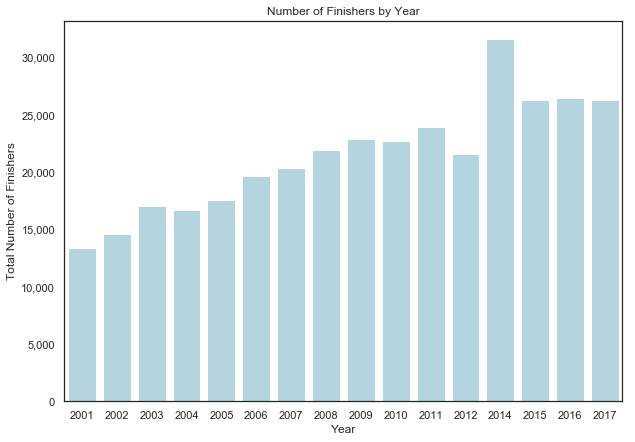

In [270]:
count_by_year = df_full.groupby('Year')['Name'].agg([('Total_Finishers', 'count')])
count_by_year = count_by_year.reset_index()

# plotting
sns.set_style('white')
plt.figure(figsize=(10, 7))

b = sns.barplot(data = count_by_year.reset_index(), x = 'Year', y = 'Total_Finishers', color = 'lightblue')
b.set(xlabel='Year', ylabel='Total Number of Finishers')
y = b.get_yticks()
b.set_yticklabels(['{:,.0f}'.format(val) for val in y])
plt.title('Number of Finishers by Year')
plt.show(b)

#### by age group

In [224]:
# Break it down in to age groups
bins= [18,20,30,40,50,60,100]
labels = ['10s','20s','30s','40s','50s', '60s+']
df_full['AgeGroup'] = pd.cut(df_full['Age'], bins=bins, labels=labels, right=False)
by_age_group = df_full.groupby(['AgeGroup', 'Year'])['Name'].agg([('Total Finishers', 'count')])
by_age_group = by_age_group.reset_index()

by_age_group_pivot = by_age_group.pivot_table(values = 'Total Finishers', index='Year', columns='AgeGroup')
pct_by_age_group = by_age_group_pivot.divide(by_age_group_pivot.sum(axis = 1), axis = 0)
pct_by_age_group

AgeGroup,10s,20s,30s,40s,50s,60s+
Year,,,,,,
2001,0.002909,0.180788,0.353222,0.322718,0.117616,0.022748
2002,0.003294,0.170807,0.346898,0.337291,0.120368,0.021342
2003,0.002525,0.161656,0.305109,0.342924,0.151028,0.036759
2004,0.003889,0.164363,0.291450,0.349907,0.150541,0.039849
2005,0.004450,0.169614,0.277955,0.350240,0.156607,0.041134
2006,0.004979,0.174118,0.266640,0.350676,0.163550,0.040037
2007,0.004378,0.178299,0.262702,0.347007,0.165658,0.041956
2008,0.004465,0.168360,0.263863,0.347246,0.167631,0.048435
2009,0.003194,0.179451,0.255196,0.342012,0.170787,0.049359


Text(0.5, 1.0, 'Boston Marathon Finishers Distribution by Age Group')

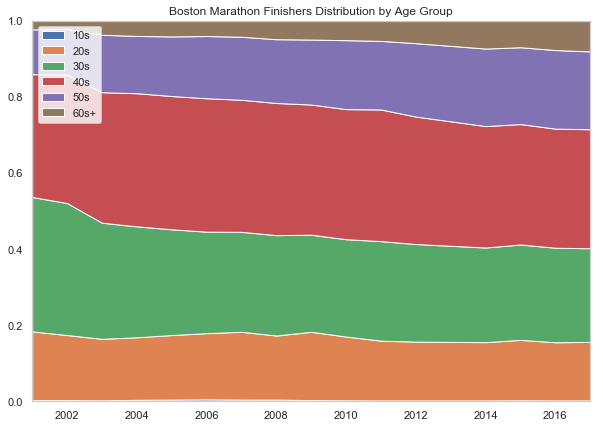

In [225]:
# plotting
plt.figure(figsize=(10, 7))

plt.stackplot(pct_by_age_group.index,
              pct_by_age_group['10s'], pct_by_age_group['20s'], pct_by_age_group['30s'],
              pct_by_age_group['40s'], pct_by_age_group['50s'], pct_by_age_group['60s+'],
              labels = ['10s', '20s', '30s', '40s', '50s', '60s+'])
plt.legend(loc = 'upper left')
plt.margins(0.1,0)
plt.xlim(2001, 2017)
plt.title('Boston Marathon Finishers Distribution by Age Group')

#### by gender

In [227]:
# Break it down in to gender
by_gender = df_full.groupby(['Gender', 'Year'])['Name'].agg([('Total Finishers', 'count')])
by_gender = by_gender.reset_index()

by_gender_pivot = by_gender.pivot_table(values = 'Total Finishers', index='Year', columns='Gender')
pct_by_gender = by_gender_pivot.divide(by_gender_pivot.sum(axis = 1), axis = 0)
pct_by_gender

Gender,F,M
Year,,
2001,0.359039,0.640961
2002,0.366319,0.633681
2003,0.370053,0.629947
2004,0.372704,0.627296
2005,0.379051,0.620949
2006,0.387207,0.612793
2007,0.392012,0.607988
2008,0.406844,0.593156
2009,0.407124,0.592876


Text(0.5, 1.0, 'Boston Marathon Finishers Distribution by Gender')

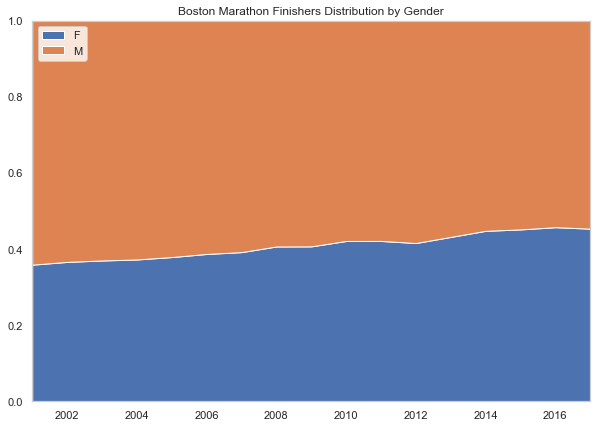

In [230]:
# plotting
plt.figure(figsize=(10, 7))

plt.stackplot(pct_by_gender.index,
              pct_by_gender['F'], pct_by_gender['M'],
              labels = ['F', 'M'])
plt.legend(loc = 'upper left')
plt.margins(0.1,0)
plt.xlim(2001, 2017)
plt.title('Boston Marathon Finishers Distribution by Gender')

#### by home country

In [244]:
df_full['Home_country'] = 'Others'
df_full.loc[df_full.Country == 'USA', 'Home_country'] = 'USA'
by_country = df_full.groupby(['Home_country', 'Year'])['Name'].agg([('Total Finishers', 'count')])
by_country = by_country.reset_index()

by_country_pivot = by_country.pivot_table(values = 'Total Finishers', index='Year', columns='Home_country')
pct_by_country = by_country_pivot.divide(by_country_pivot.sum(axis = 1), axis = 0)
pct_by_country

Home_country,Others,USA
Year,,
2001,0.102700,0.897300
2002,0.106506,0.893494
2003,0.114680,0.885320
2004,0.120984,0.879016
2005,0.130420,0.869580
2006,0.137130,0.862870
2007,0.139541,0.860459
2008,0.147264,0.852736
2009,0.151271,0.848729


Text(0.5, 1.0, 'Boston Marathon Finishers Distribution by Origin Country (USA vs Others)')

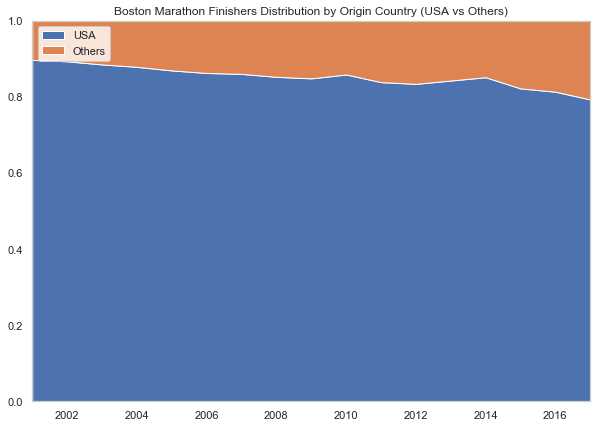

In [248]:
# plotting
plt.figure(figsize=(10, 7))

plt.stackplot(pct_by_country.index,
              pct_by_country['USA'], pct_by_country['Others'],
              labels = ['USA', 'Others'])
plt.legend(loc = 'upper left')
plt.margins(0.1,0)
plt.xlim(2001, 2017)
plt.title('Boston Marathon Finishers Distribution by Origin Country (USA vs Others)')

In [265]:
# Top 10 countries in terms of participants
counts_by_country = df_full[df_full.Year == 2017].groupby(['Country'])['Name']\
                           .agg([('total','count')])\
                           .sort_values(by = 'total', ascending=False).reset_index()
counts_by_country[0:10]

,Country,total
0,USA,20829
1,CAN,1854
2,GBR,425
3,MEX,283
4,CHN,241
5,GER,225
6,BRA,205
7,AUS,188
8,JPN,170
9,ITA,163


In [266]:
# Top 10 countries in terms of average finishing time
avg_time_by_country = df_full[df_full.Year == 2017].groupby(['Country'])['Official']\
                             .agg([('Avg Finishing Time','mean')])\
                             .sort_values(by = 'Avg Finishing Time').reset_index()
summary_by_country = avg_time_by_country.merge(counts_by_country, left_on = 'Country', right_on = 'Country')
summary_by_country.columns = ['Country', 'Avg Finishing Time', 'Number of runners']
summary_by_country[0:10]

,Country,Avg Finishing Time,Number of runners
0,ZIM,137.670,1
1,KEN,141.320,8
2,BRN,142.850,1
3,ETH,147.146,5
4,BDI,152.400,1
5,PAN,183.040,4
6,FLK,190.400,1
7,JAM,192.000,1
8,SRB,193.350,1
9,MLT,194.430,1


#### What’s the distribution of performance(finishing time) look like among all the runners?

[(100, 500)]

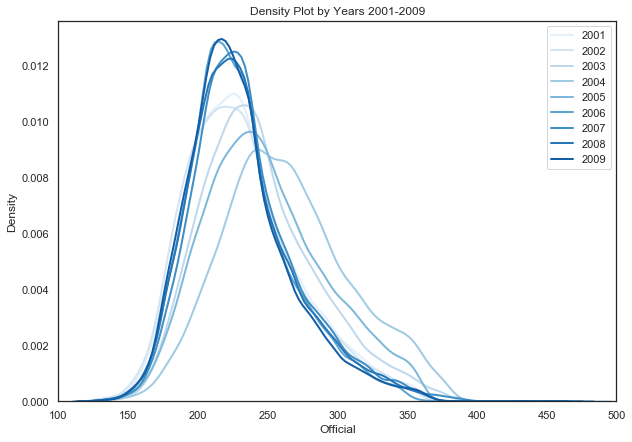

In [271]:
# Density Plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

years = range(2001, 2010)

# Plot formatting
sns.set_style('white')
plt.figure(figsize=(10, 7))
plt.title('Density Plot by Years 2001-2009')
plt.xlabel('Official Finishing Time')
plt.ylabel('Density')

# Iterate through the years
for year in years:
    # Subset to each year
    subset = df_full[df_full['Year'] == year]
    
    # Draw the density plot
    g = sns.distplot(subset['Official'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = year,
                 color = sns.color_palette("Blues", 10)[year-2001])
    

g.set(xlim=(100,500))


[(100, 500)]

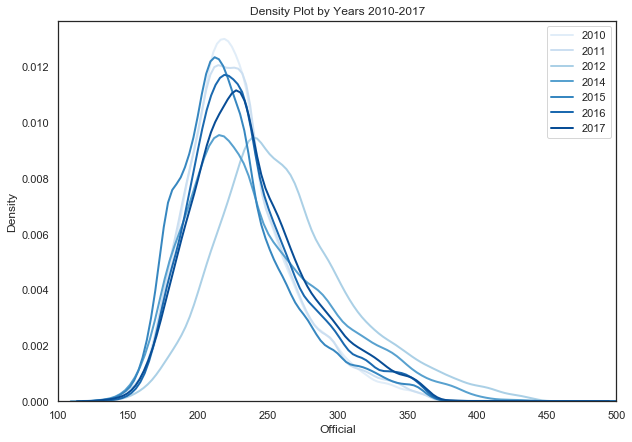

In [272]:
# Density Plot
import matplotlib.pyplot as plt
import seaborn as sns

years = range(2010, 2018)

# Plot formatting
sns.set_style('white')
plt.figure(figsize=(10, 7))
plt.title('Density Plot by Years 2010-2017')
plt.xlabel('Official Finishing Time')
plt.ylabel('Density')

# Iterate through the years
for year in years:
    # Subset to each year
    subset = df_full[df_full['Year'] == year]
    
    # Draw the density plot
    g = sns.distplot(subset['Official'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = year,
                 color = sns.color_palette("Blues", 8)[year-2010])
g.set(xlim=(100,500))    

[(100, 500)]

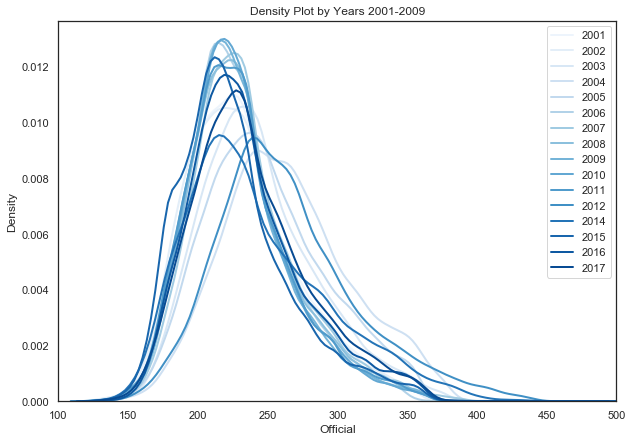

In [273]:
# Density Plot - full year
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

years = range(2001, 2018)

# Plot formatting
sns.set_style('white')
plt.figure(figsize=(10, 7))
plt.title('Density Plot by Years 2001-2009')
plt.xlabel('Official Finishing Time')
plt.ylabel('Density')

# Iterate through the years
for year in years:
    # Subset to each year
    subset = df_full[df_full['Year'] == year]
    
    # Draw the density plot
    g = sns.distplot(subset['Official'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = year,
                 color = sns.color_palette("Blues", 18)[year-2001])
    

g.set(xlim=(100,500))

#### What’s the effect of weather on runner's finishing time?
I pulled the weather data from Boston Marathon Official website: https://www.baa.org/races/boston-marathon/results/history

In [287]:
Weather_Data = pd.read_csv('Boston_Marathon_Weather.csv')
Weather_Data

,YEAR,HOPKINTON TEMP,BOSTON TEMP,WIND,SKY
0,2000,50,47,N/NE 7–12 mph,Cloudy
1,2001,53,54,N/NE 1–5 mph,Partly Cloudy
2,2002,53,56,N/NE 1–5 mph,Mostly Cloudy
3,2003,70,59,Variable 3–8 mph,Clear
4,2004,83,86,WSW/SW/W 8–11 mph,Cloudy
5,2005,70,66,E/NE 5–8 mph,Clear
6,2006,55,53,N 10 mph,Clear
7,2007,47,50,E/ESE 20–30 mph,Overcast and Rain
8,2008,53,53,W 2 mph,Clear
9,2009,51,47,E/SE 9–16 mph,Partly Cloudy


I will use 3 attributes to look at the trend in the average finishing time - temperature, wind speed, and sky condition. 

#### Temperature - Max, Min, and Average

In [288]:
Weather_Data['Min_temp'] = Weather_Data[['HOPKINTON TEMP', 'BOSTON TEMP']].min(axis=1)
Weather_Data['Max_temp'] = Weather_Data[['HOPKINTON TEMP', 'BOSTON TEMP']].max(axis=1)
Weather_Data['Avg_temp'] = Weather_Data[['HOPKINTON TEMP', 'BOSTON TEMP']].mean(axis=1)
Weather_Data

,YEAR,HOPKINTON TEMP,BOSTON TEMP,WIND,SKY,Min_temp,Max_temp,Avg_temp
0,2000,50,47,N/NE 7–12 mph,Cloudy,47,50,48.5
1,2001,53,54,N/NE 1–5 mph,Partly Cloudy,53,54,53.5
2,2002,53,56,N/NE 1–5 mph,Mostly Cloudy,53,56,54.5
3,2003,70,59,Variable 3–8 mph,Clear,59,70,64.5
4,2004,83,86,WSW/SW/W 8–11 mph,Cloudy,83,86,84.5
5,2005,70,66,E/NE 5–8 mph,Clear,66,70,68.0
6,2006,55,53,N 10 mph,Clear,53,55,54.0
7,2007,47,50,E/ESE 20–30 mph,Overcast and Rain,47,50,48.5
8,2008,53,53,W 2 mph,Clear,53,53,53.0
9,2009,51,47,E/SE 9–16 mph,Partly Cloudy,47,51,49.0


#### average wind speed

In [297]:
Weather_Data['Min_wind_speed'] = Weather_Data['WIND'].str.extract(r' (\d*)').astype(int)
Weather_Data['Max_wind_speed'] = Weather_Data['WIND'].str.extract(r'(\w*) mph').astype(int)
Weather_Data['Avg_wind_speed'] = Weather_Data[['Min_wind_speed', 'Max_wind_speed']].mean(axis=1)
Weather_Data

,YEAR,HOPKINTON TEMP,BOSTON TEMP,WIND,SKY,Min_temp,Max_temp,Avg_temp,Min_wind_speed,Max_wind_speed,Avg_wind_speed
0,2000,50,47,N/NE 7–12 mph,Cloudy,47,50,48.5,7,12,9.5
1,2001,53,54,N/NE 1–5 mph,Partly Cloudy,53,54,53.5,1,5,3.0
2,2002,53,56,N/NE 1–5 mph,Mostly Cloudy,53,56,54.5,1,5,3.0
3,2003,70,59,Variable 3–8 mph,Clear,59,70,64.5,3,8,5.5
4,2004,83,86,WSW/SW/W 8–11 mph,Cloudy,83,86,84.5,8,11,9.5
5,2005,70,66,E/NE 5–8 mph,Clear,66,70,68.0,5,8,6.5
6,2006,55,53,N 10 mph,Clear,53,55,54.0,10,10,10.0
7,2007,47,50,E/ESE 20–30 mph,Overcast and Rain,47,50,48.5,20,30,25.0
8,2008,53,53,W 2 mph,Clear,53,53,53.0,2,2,2.0
9,2009,51,47,E/SE 9–16 mph,Partly Cloudy,47,51,49.0,9,16,12.5


#### sky condition

In [385]:
Weather_Data['sky_condition'] = 1
Weather_Data.loc[Weather_Data.SKY.str.contains(r'Cloudy'), 'sky_condition'] = 2
Weather_Data.loc[Weather_Data.SKY.str.contains(r'Rain'), 'sky_condition'] = 3
Weather_Data

,YEAR,HOPKINTON TEMP,BOSTON TEMP,WIND,SKY,Min_temp,Max_temp,Avg_temp,Min_wind_speed,Max_wind_speed,Avg_wind_speed,sky_condition
0,2000,50,47,N/NE 7–12 mph,Cloudy,47,50,48.5,7,12,9.5,2
1,2001,53,54,N/NE 1–5 mph,Partly Cloudy,53,54,53.5,1,5,3.0,2
2,2002,53,56,N/NE 1–5 mph,Mostly Cloudy,53,56,54.5,1,5,3.0,2
3,2003,70,59,Variable 3–8 mph,Clear,59,70,64.5,3,8,5.5,1
4,2004,83,86,WSW/SW/W 8–11 mph,Cloudy,83,86,84.5,8,11,9.5,2
5,2005,70,66,E/NE 5–8 mph,Clear,66,70,68.0,5,8,6.5,1
6,2006,55,53,N 10 mph,Clear,53,55,54.0,10,10,10.0,1
7,2007,47,50,E/ESE 20–30 mph,Overcast and Rain,47,50,48.5,20,30,25.0,3
8,2008,53,53,W 2 mph,Clear,53,53,53.0,2,2,2.0,1
9,2009,51,47,E/SE 9–16 mph,Partly Cloudy,47,51,49.0,9,16,12.5,2


Text(0.5, 0, 'Average Finishing Time (in minutes)')

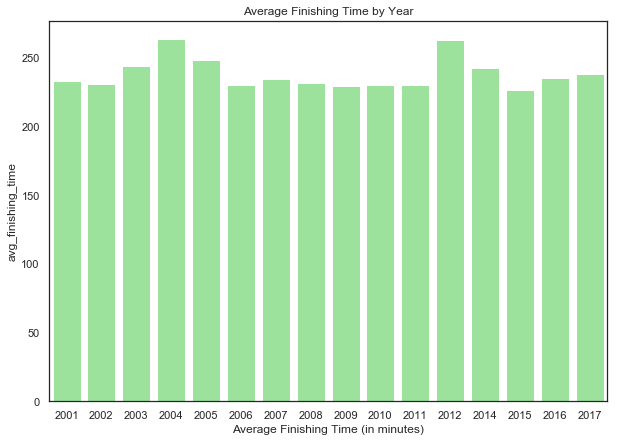

In [391]:
# look at average finishing time first
mean_by_year = df_full.groupby('Year')['Official'].agg([('avg_finishing_time', 'mean')])
mean_by_year = mean_by_year.reset_index()

sns.set_style('white')
plt.figure(figsize=(10, 7))
sns.barplot(data = mean_by_year.reset_index(), x = 'Year', y = 'avg_finishing_time', color = 'Lightgreen')
plt.title('Average Finishing Time by Year')
plt.xlabel('Average Finishing Time (in minutes)')

In [393]:
# merge with marathon data
mean_by_year = mean_by_year.merge(Weather_Data, left_on='Year', right_on = 'YEAR')
mean_by_year

,Year,avg_finishing_time,YEAR,HOPKINTON TEMP,BOSTON TEMP,WIND,SKY,Min_temp,Max_temp,Avg_temp,Min_wind_speed,Max_wind_speed,Avg_wind_speed,sky_condition
0,2001,232.965168,2001,53,54,N/NE 1–5 mph,Partly Cloudy,53,54,53.5,1,5,3.0,2
1,2002,231.109430,2002,53,56,N/NE 1–5 mph,Mostly Cloudy,53,56,54.5,1,5,3.0,2
2,2003,244.100473,2003,70,59,Variable 3–8 mph,Clear,59,70,64.5,3,8,5.5,1
3,2004,263.603142,2004,83,86,WSW/SW/W 8–11 mph,Cloudy,83,86,84.5,8,11,9.5,2
4,2005,248.409544,2005,70,66,E/NE 5–8 mph,Clear,66,70,68.0,5,8,6.5,1
5,2006,230.107669,2006,55,53,N 10 mph,Clear,53,55,54.0,10,10,10.0,1
6,2007,234.517458,2007,47,50,E/ESE 20–30 mph,Overcast and Rain,47,50,48.5,20,30,25.0,3
7,2008,231.668751,2008,53,53,W 2 mph,Clear,53,53,53.0,2,2,2.0,1
8,2009,229.567789,2009,51,47,E/SE 9–16 mph,Partly Cloudy,47,51,49.0,9,16,12.5,2
9,2010,229.716445,2010,49,55,E/NE 2–5 mph,Partly Cloudy,49,55,52.0,2,5,3.5,2


Text(0, 0.5, 'Average Temperature')

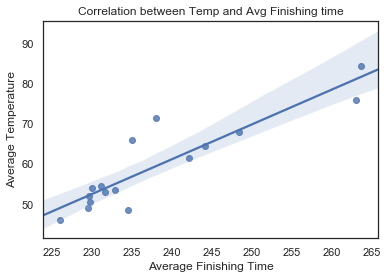

In [395]:
sns.regplot('avg_finishing_time','Avg_temp', data = mean_by_year)
plt.title('Correlation between Temp and Avg Finishing time')
plt.xlabel('Average Finishing Time')
plt.ylabel('Average Temperature')

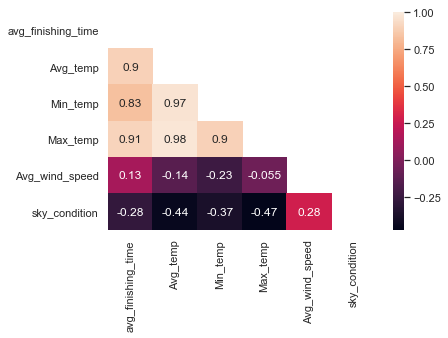

In [396]:
c = mean_by_year[['avg_finishing_time', 'Avg_temp', 'Min_temp', 'Max_temp', 'Avg_wind_speed', 'sky_condition']]\
                .corr()
mask = np.ones_like(c, dtype = np.bool)
mask = np.triu(mask)
sns.heatmap(c, annot = True, mask = mask)